In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from IMV_LSTM.networks import IMVTensorLSTM
from IMV_LSTM.min_max_scaler import SeriesMinMaxScaler

原始数据结构：

- 包含 `data1` 和 `data2` 两个原始数据集。
- 每个数据集都是时间序列，15分钟一条数据。
- Single output (target) data: 3:Temperature_Comedor_Sensor 。
- Multi-input data: 包含 output 在内，共 17 个 ($N=17$)。

In [2]:
data1 = pd.read_csv("./TS_datasets/SML2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("./TS_datasets/SML2010/NEW-DATA-2.T15.txt", sep=' ')

data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [3]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

train_size = 3200
val_size = 400
# ? 什么是 depth？
# * 个人猜测：depth 就是 seq_length，这可以从下文中 X_train1 的构造过程中看出来
depth = 10
batch_size = 128
prediction_horizon = 1

In [4]:
# * 第 0 维度 --> 不同时间下的 time sequence
# * 第 1 维度 --> 不同 depth (可以理解为时延) 下的 time sequence
# * 第 2 维度 --> features
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).bfill()
y_train1 = data1[target].shift(-prediction_horizon).ffill()
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).bfill()
y2 = data2[target].shift(-prediction_horizon).ffill()
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

print(X_train.shape, y_train.shape)

(3179, 10, 17) (3179,)


In [5]:
x_scaler = SeriesMinMaxScaler()
y_scaler = SeriesMinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

In [6]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [7]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)

In [8]:
model = IMVTensorLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [ ]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5 # * 实际上算的是 rmse_val
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = y_scaler.inverse_transform(preds)
        true = y_scaler.inverse_transform(true)
        rmse = root_mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("rmse: ", rmse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

#### Load checkpoint

In [10]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

<All keys matched successfully>

In [11]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

preds = y_scaler.inverse_transform(preds)
true = y_scaler.inverse_transform(true)

rmse = root_mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
print("rmse: ", rmse, "mae: ", mae)

print(alphas.shape, betas.shape)

rmse:  0.3818366825580597 mae:  0.27811476588249207
(537, 10, 17, 1) (537, 17, 1)


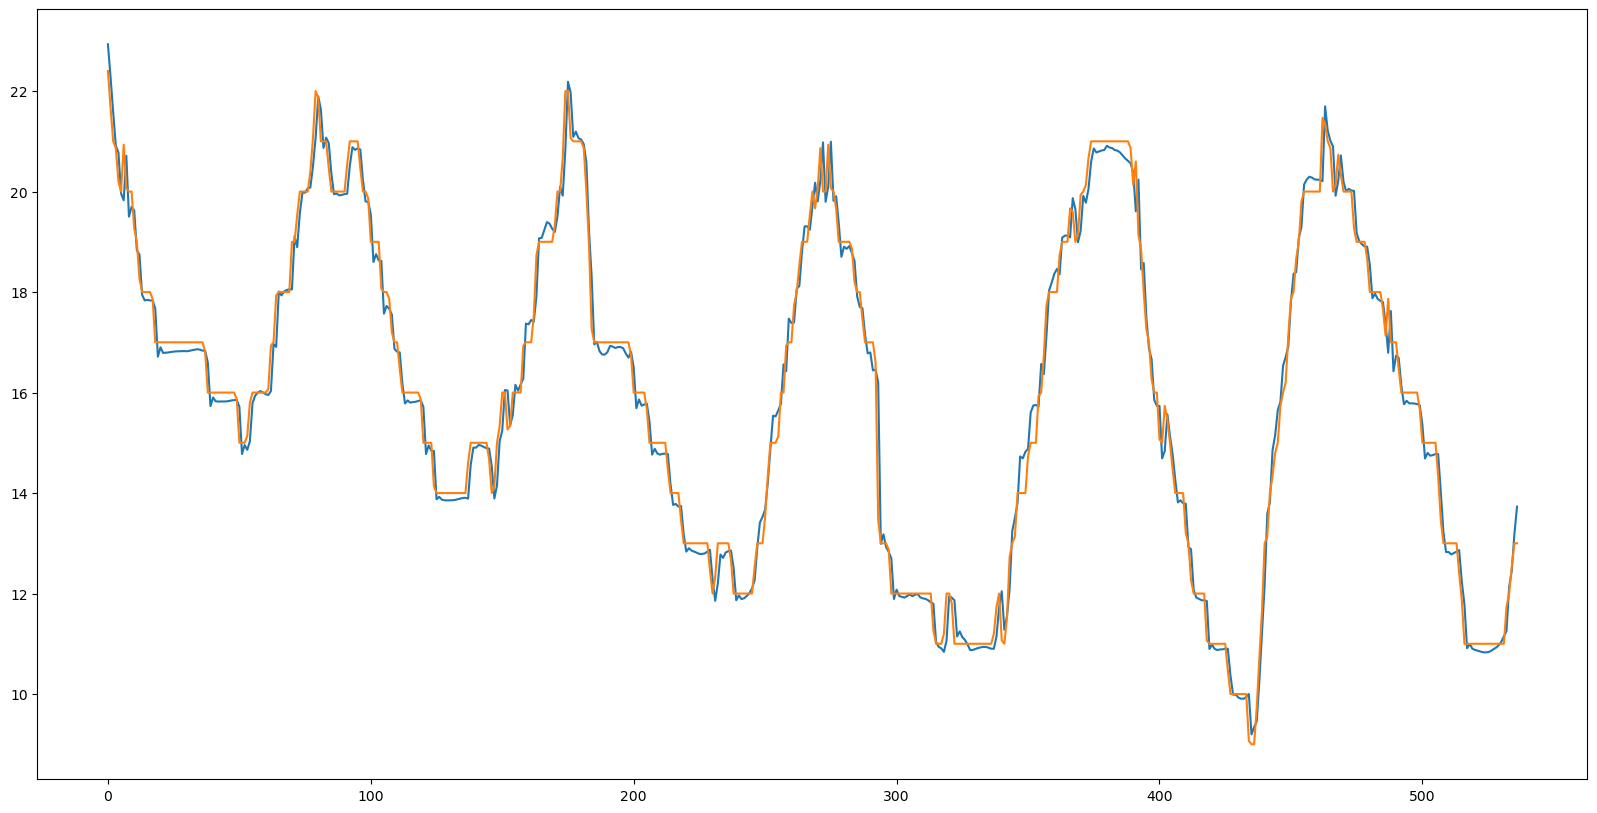

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [13]:
# * 取平均前：alphas -> (sample_size, seq_len, input_dim, 1)
# * 取平均后：alphas -> (seq_len, input_dim, 1)
alphas = alphas.mean(axis=0)
# * 取平均前：betas -> (sample_size, input_dim, 1)
# * 取平均后：betas -> (input_dim, 1)
betas = betas.mean(axis=0)
# * [..., 0] 表示切片操作 ==> 在最后一个维度上选择索引为 0 的元素。
# * 切片后 alphas -> (sample_size, input_dim)
alphas = alphas[..., 0]
# * 切片后 betas -> (input_dim) (1维Tensor)
betas = betas[..., 0]
# * transpose 专门用于交换Tensor的两个维度（Tensor本身可以多于2维），
# * 是 permute 的特例，且比 permute 更高效。
alphas = alphas.transpose(1, 0)

以下三种写法等价：

```Python
alphas = alphas[..., 0]
alphas = alphas[:, :, 0]
alphas = alphas.squeeze(-1)  # 如果最后一个维度是1
```

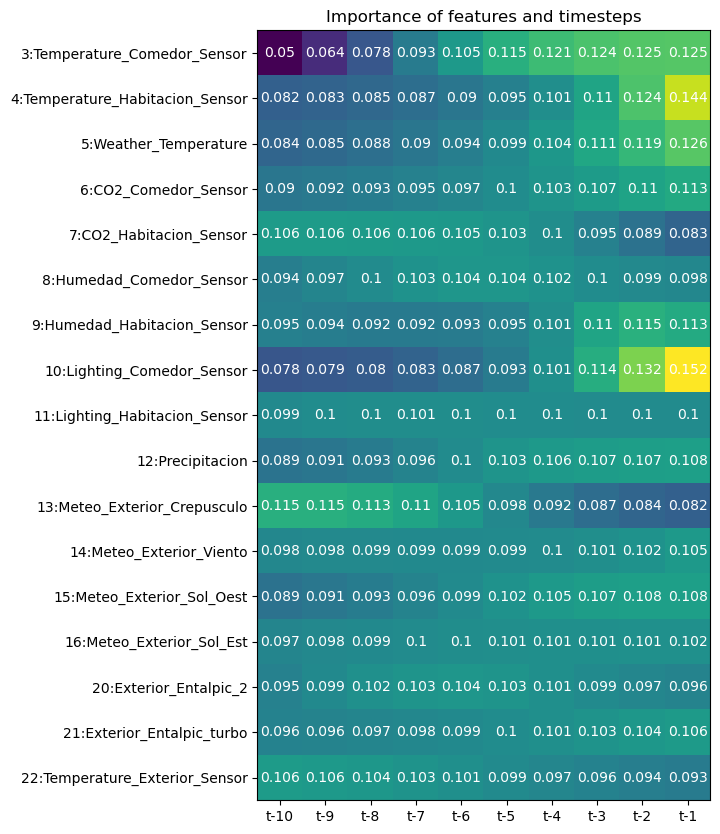

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x126815113d0>,
 [Text(0, 0, '3:Temperature_Comedor_Sensor'),
  Text(1, 0, '4:Temperature_Habitacion_Sensor'),
  Text(2, 0, '5:Weather_Temperature'),
  Text(3, 0, '6:CO2_Comedor_Sensor'),
  Text(4, 0, '7:CO2_Habitacion_Sensor'),
  Text(5, 0, '8:Humedad_Comedor_Sensor'),
  Text(6, 0, '9:Humedad_Habitacion_Sensor'),
  Text(7, 0, '10:Lighting_Comedor_Sensor'),
  Text(8, 0, '11:Lighting_Habitacion_Sensor'),
  Text(9, 0, '12:Precipitacion'),
  Text(10, 0, '13:Meteo_Exterior_Crepusculo'),
  Text(11, 0, '14:Meteo_Exterior_Viento'),
  Text(12, 0, '15:Meteo_Exterior_Sol_Oest'),
  Text(13, 0, '16:Meteo_Exterior_Sol_Est'),
  Text(14, 0, '20:Exterior_Entalpic_2'),
  Text(15, 0, '21:Exterior_Entalpic_turbo'),
  Text(16, 0, '22:Temperature_Exterior_Sensor')])

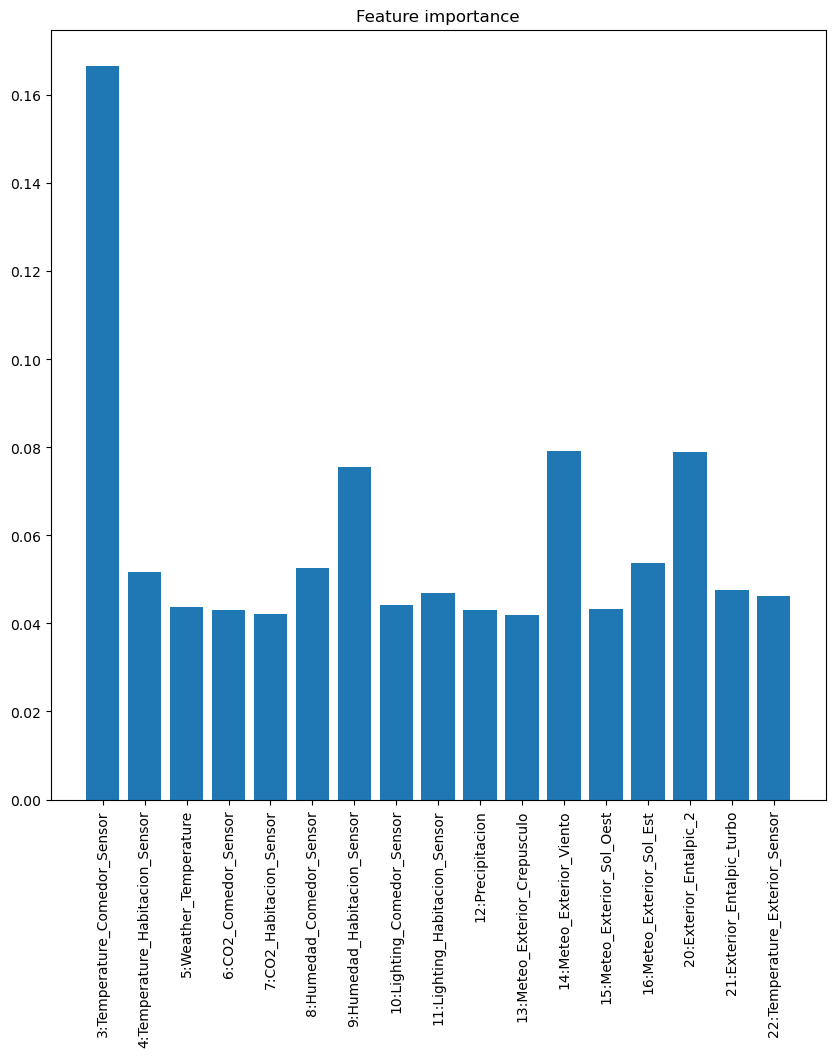

In [15]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

## freeze weights 

In [16]:
attention_layers = ["F_alpha_n",
                "F_alpha_n_b",
                "F_beta_n",
                "F_beta_n_b",
                "F_alpha_1.bias",
                "F_alpha_1.weight",
                "F_beta_1.bias",
                "F_beta_1.weight"]
# * PyTorch 没有一键 freeze 的默认方法，此处的代码就是 PyTorch 里默认实现
# * freeze params 的方式。
for p in model.named_parameters():
    if p[0] not in attention_layers:
        p[1].requires_grad = False

### Train only attention layers

In [ ]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = y_scaler.inverse_transform(preds)
        true = y_scaler.inverse_transform(true)
        mse = root_mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("rmse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

### Evaluation

In [18]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas_freeze_1 = []
    betas_freeze_1 = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas_freeze_1.append(a.detach().cpu().numpy())
        betas_freeze_1.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas_freeze_1 = np.concatenate(alphas_freeze_1)
betas_freeze_1 = np.concatenate(betas_freeze_1)
alphas_freeze_1 = alphas_freeze_1.mean(axis=0)
betas_freeze_1 = betas_freeze_1.mean(axis=0)
alphas_freeze_1 = alphas_freeze_1[..., 0]
betas_freeze_1 = betas_freeze_1[..., 0]
alphas_freeze_1 = alphas_freeze_1.transpose(1, 0)

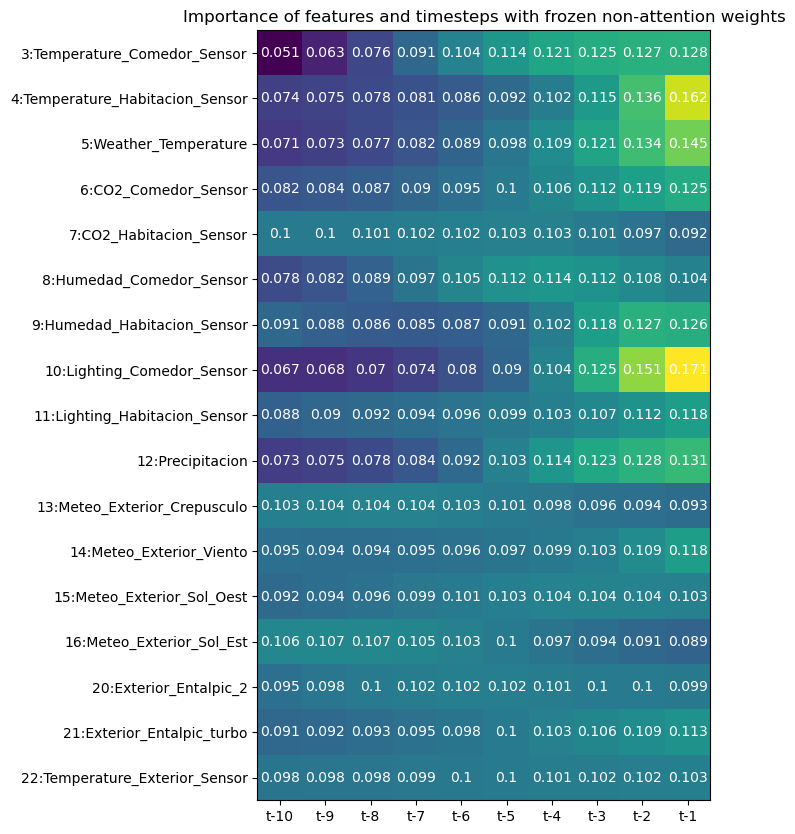

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_freeze_1)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_freeze_1[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps with frozen non-attention weights")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x126d1c4b740>,
 [Text(0, 0, '3:Temperature_Comedor_Sensor'),
  Text(1, 0, '4:Temperature_Habitacion_Sensor'),
  Text(2, 0, '5:Weather_Temperature'),
  Text(3, 0, '6:CO2_Comedor_Sensor'),
  Text(4, 0, '7:CO2_Habitacion_Sensor'),
  Text(5, 0, '8:Humedad_Comedor_Sensor'),
  Text(6, 0, '9:Humedad_Habitacion_Sensor'),
  Text(7, 0, '10:Lighting_Comedor_Sensor'),
  Text(8, 0, '11:Lighting_Habitacion_Sensor'),
  Text(9, 0, '12:Precipitacion'),
  Text(10, 0, '13:Meteo_Exterior_Crepusculo'),
  Text(11, 0, '14:Meteo_Exterior_Viento'),
  Text(12, 0, '15:Meteo_Exterior_Sol_Oest'),
  Text(13, 0, '16:Meteo_Exterior_Sol_Est'),
  Text(14, 0, '20:Exterior_Entalpic_2'),
  Text(15, 0, '21:Exterior_Entalpic_turbo'),
  Text(16, 0, '22:Temperature_Exterior_Sensor')])

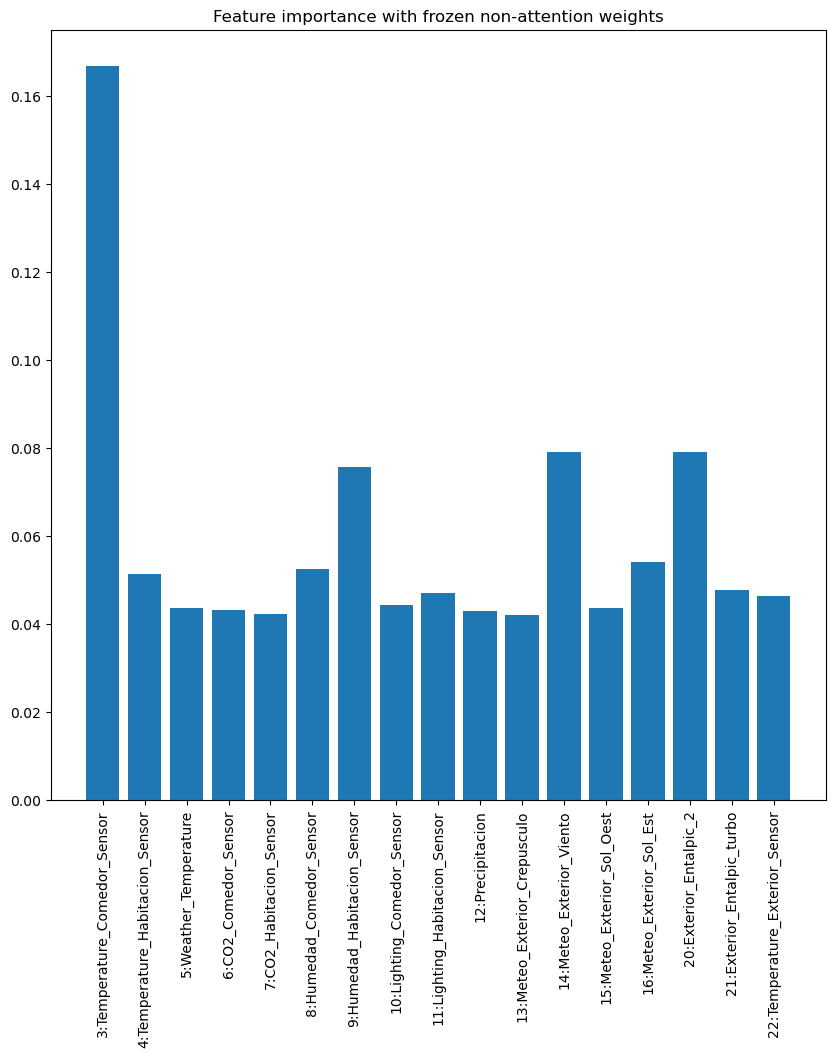

In [20]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance with frozen non-attention weights")
plt.bar(range(len(cols)), betas_freeze_1)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

## train another model

此模型与前一个模型在设置上完全相同，不同只是因为训练时的 randomness。

In [ ]:
model = IMVTensorLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = y_scaler.inverse_transform(preds)
        true = y_scaler.inverse_transform(true)
        mse = root_mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

#### freeze layers

In [22]:
for p in model.named_parameters():
    if p[0] not in attention_layers:
        p[1].requires_grad = False

### train attention weights of second model

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = y_scaler.inverse_transform(preds)
        true = y_scaler.inverse_transform(true)
        mse = root_mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

#### Evaluation

In [24]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas_freeze_2 = []
    betas_freeze_2 = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas_freeze_2.append(a.detach().cpu().numpy())
        betas_freeze_2.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas_freeze_2 = np.concatenate(alphas_freeze_2)
betas_freeze_2 = np.concatenate(betas_freeze_2)
alphas_freeze_2 = alphas_freeze_2.mean(axis=0)
betas_freeze_2 = betas_freeze_2.mean(axis=0)
alphas_freeze_2 = alphas_freeze_2[..., 0]
betas_freeze_2 = betas_freeze_2[..., 0]
alphas_freeze_2 = alphas_freeze_2.transpose(1, 0)

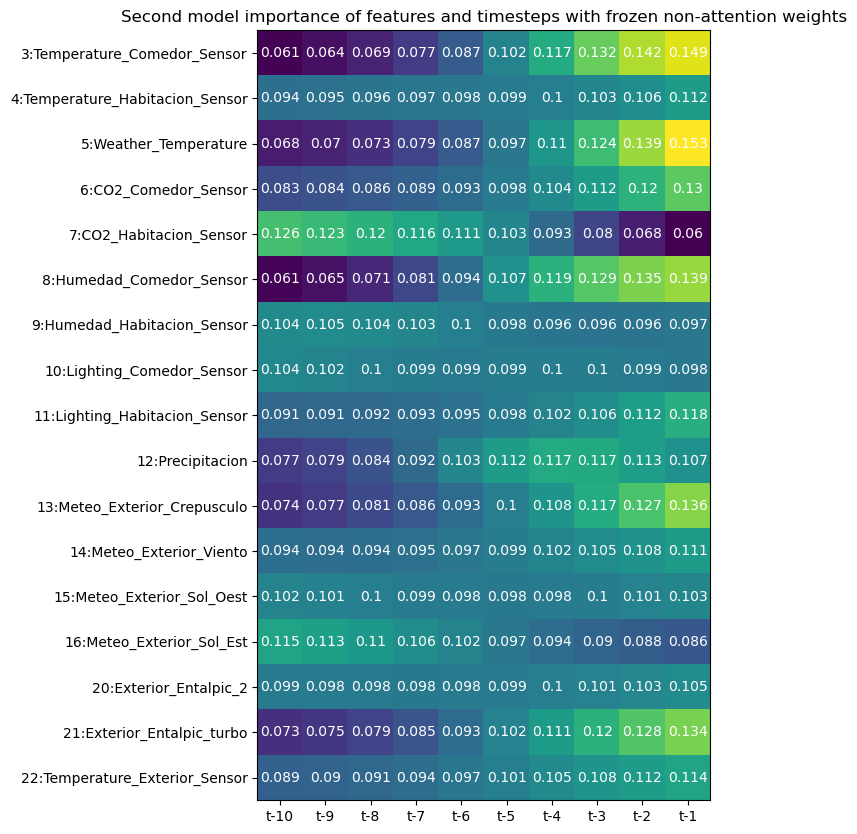

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_freeze_2)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_freeze_2[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Second model importance of features and timesteps with frozen non-attention weights")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x12683eef920>,
 [Text(0, 0, '3:Temperature_Comedor_Sensor'),
  Text(1, 0, '4:Temperature_Habitacion_Sensor'),
  Text(2, 0, '5:Weather_Temperature'),
  Text(3, 0, '6:CO2_Comedor_Sensor'),
  Text(4, 0, '7:CO2_Habitacion_Sensor'),
  Text(5, 0, '8:Humedad_Comedor_Sensor'),
  Text(6, 0, '9:Humedad_Habitacion_Sensor'),
  Text(7, 0, '10:Lighting_Comedor_Sensor'),
  Text(8, 0, '11:Lighting_Habitacion_Sensor'),
  Text(9, 0, '12:Precipitacion'),
  Text(10, 0, '13:Meteo_Exterior_Crepusculo'),
  Text(11, 0, '14:Meteo_Exterior_Viento'),
  Text(12, 0, '15:Meteo_Exterior_Sol_Oest'),
  Text(13, 0, '16:Meteo_Exterior_Sol_Est'),
  Text(14, 0, '20:Exterior_Entalpic_2'),
  Text(15, 0, '21:Exterior_Entalpic_turbo'),
  Text(16, 0, '22:Temperature_Exterior_Sensor')])

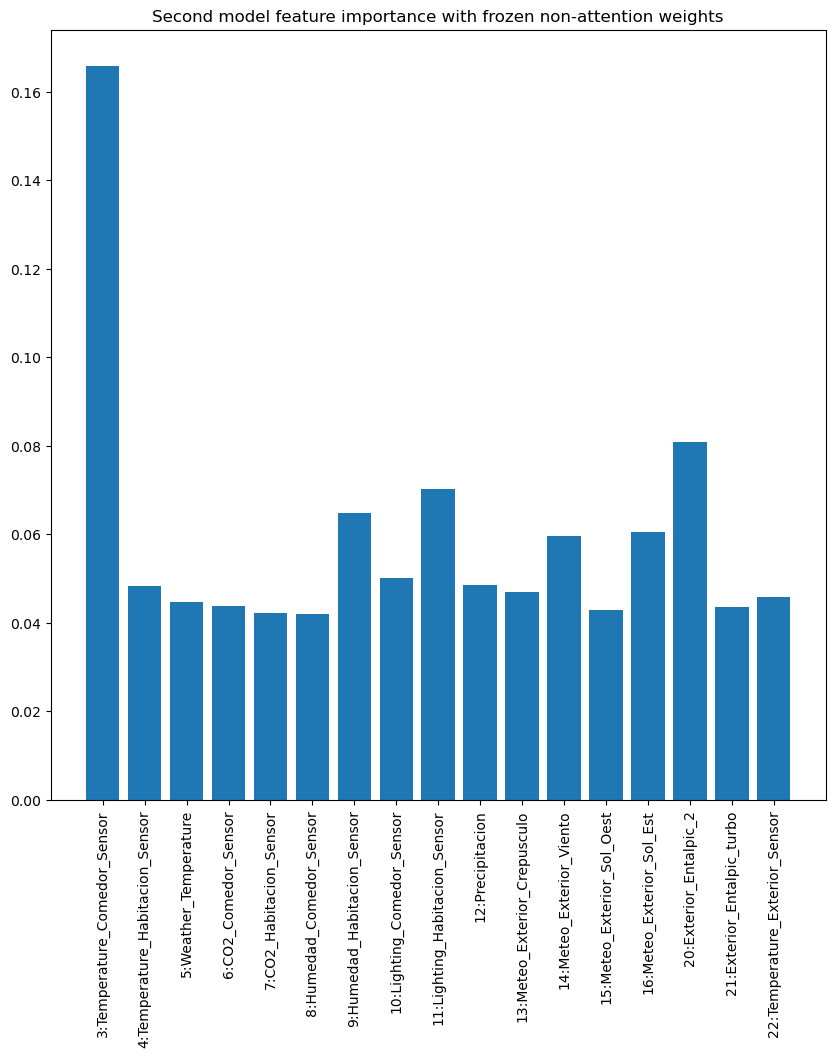

In [26]:
plt.figure(figsize=(10, 10))
plt.title("Second model feature importance with frozen non-attention weights")
plt.bar(range(len(cols)), betas_freeze_2)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

### difference between two runs

In [27]:
alphas_diff = np.abs(alphas_freeze_2 - alphas_freeze_1)

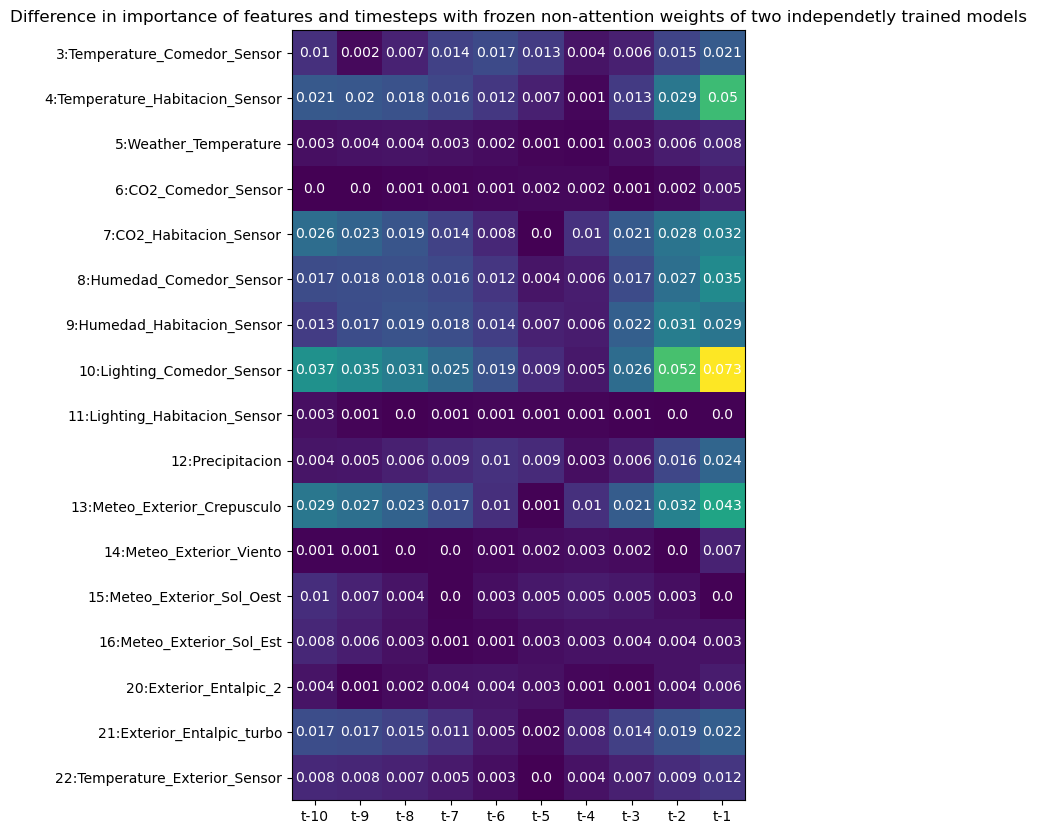

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_diff)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_diff[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Difference in importance of features and timesteps with frozen non-attention weights of two independetly trained models")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x126812b5af0>,
 [Text(0, 0, '3:Temperature_Comedor_Sensor'),
  Text(1, 0, '4:Temperature_Habitacion_Sensor'),
  Text(2, 0, '5:Weather_Temperature'),
  Text(3, 0, '6:CO2_Comedor_Sensor'),
  Text(4, 0, '7:CO2_Habitacion_Sensor'),
  Text(5, 0, '8:Humedad_Comedor_Sensor'),
  Text(6, 0, '9:Humedad_Habitacion_Sensor'),
  Text(7, 0, '10:Lighting_Comedor_Sensor'),
  Text(8, 0, '11:Lighting_Habitacion_Sensor'),
  Text(9, 0, '12:Precipitacion'),
  Text(10, 0, '13:Meteo_Exterior_Crepusculo'),
  Text(11, 0, '14:Meteo_Exterior_Viento'),
  Text(12, 0, '15:Meteo_Exterior_Sol_Oest'),
  Text(13, 0, '16:Meteo_Exterior_Sol_Est'),
  Text(14, 0, '20:Exterior_Entalpic_2'),
  Text(15, 0, '21:Exterior_Entalpic_turbo'),
  Text(16, 0, '22:Temperature_Exterior_Sensor')])

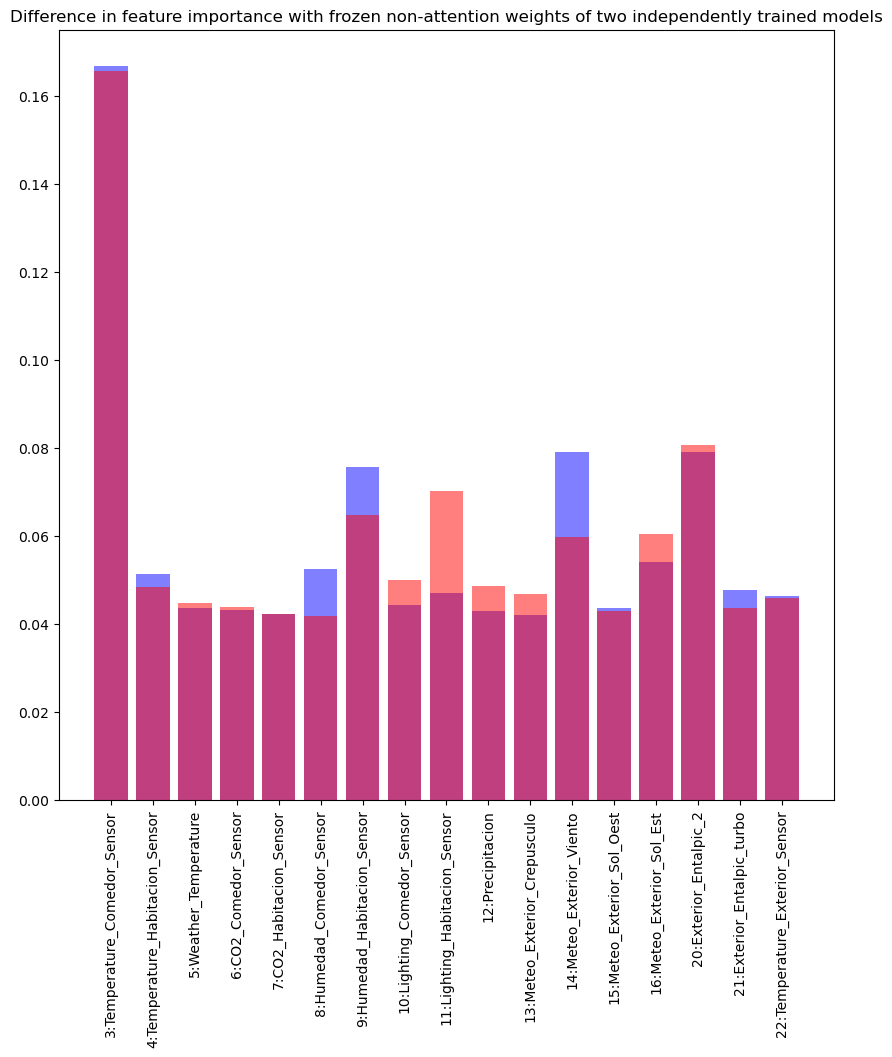

In [29]:
plt.figure(figsize=(10, 10))
plt.title("Difference in feature importance with frozen non-attention weights of two independently trained models")
plt.bar(range(len(cols)), betas_freeze_1, fc=(0, 0, 1, 0.5))
plt.bar(range(len(cols)), betas_freeze_2, fc=(1, 0, 0, 0.5))
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)